## 使用AIX自带的faithfulness_metric和monotonicity_metric评估解释效果

In [1]:
import numpy as np
import pandas as pd 
import xgboost 
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import train_test_split
import sys
sys.path.append("..")
from evaluate import IoU_value
from evaluate import faithfulness_metric,monotonicity_metric

**源代码中的faithfulness_metric实现方法：<br />**
```python
def faithfulness_metric(model, x, coefs, base):
    #find predicted class
    pred_class = np.argmax(model.predict_proba(x.reshape(1,-1)), axis=1)[0]

    #find indexs of coefficients in decreasing order of value
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]

    return -np.corrcoef(coefs, pred_probs)[0,1]
```

**源代码中的monotonicty_metric实现方法:<br />**
```python
def monotonicity_metric(model, x, coefs, base):
    #find predicted class
    pred_class = np.argmax(model.predict_proba(x.reshape(1,-1)), axis=1)[0]

    x_copy = base.copy()

    #find indexs of coefficients in increasing order of value
    ar = np.argsort(coefs)
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]

    return np.all(np.diff(pred_probs[ar]) >= 0)
```

**其中输入输出分别为：<br />**
```
Args:
    model: Trained classifier, such as a ScikitClassifier that implements
        a predict() and a predict_proba() methods.
    x (numpy.ndarray): row of data.
    coefs (numpy.ndarray): coefficients (weights) corresponding to attribute importance.
    base ((numpy.ndarray): base (default) values of attributes

Returns:
    float: correlation between attribute importance weights and corresponding effect on classifier.
```

## 简单的测试

In [2]:
#from aix360.metrics import faithfulness_metric, monotonicity_metric
df = pd.read_csv("train/train_data_0.csv")
df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,84.071517,15,95,37,109.222187,41.054423,14,12.635977,14.010126,70,...,26,56,32,30,30,65,36.400093,55,44,11.299354
1,64.376450,12,39,40,108.267721,58.627029,46,80.431019,3.598875,70,...,28,38,69,28,10,44,32.313545,30,45,10.109159
2,61.747596,36,58,7,51.315514,10.865075,53,43.284407,52.822478,70,...,20,45,62,43,29,48,35.294801,27,70,11.926330
3,108.096804,32,73,59,40.416383,12.580249,70,19.908695,59.408556,70,...,26,7,57,68,3,42,37.391035,47,71,10.819648
4,93.659688,14,45,30,85.312636,47.390543,81,30.780931,44.901262,71,...,30,10,46,42,3,42,32.743209,42,47,11.301096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46.443361,29,59,22,41.987071,57.629751,39,78.792761,4.834577,71,...,26,63,38,66,16,62,36.587602,31,50,7.942675
9996,101.995631,23,57,16,100.037233,41.170912,25,32.059358,31.253103,71,...,29,57,44,52,7,62,37.806850,31,70,11.128170
9997,79.100888,42,36,44,100.913728,59.806790,17,69.167360,47.454068,70,...,22,60,46,4,32,62,32.413842,52,59,10.260244
9998,97.844526,31,41,46,52.108113,51.004928,65,39.811859,36.990671,70,...,25,20,42,4,19,47,36.201993,27,54,8.643205


In [3]:
def normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x.max() == x.min():
        return x
    else:
        result = (x-x_min)/(x_max-x_min)
        return result
df["label"] = df.feature0 *1 + df.feature1 * 1 + df.feature3*1
df["label"] = (normalize(df["label"])>0.5).astype(int)

In [4]:
data = df.iloc[:,:-1]
label = df.iloc[:,-1]
X_train,X_test, y_train,y_test = train_test_split(data,label,test_size = 0.3)
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train,y_train)
xgb_clf.score(X_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.98

Intercept 0.6080123251429234
Prediction_local [0.26956943]
Right: 0.00029588942


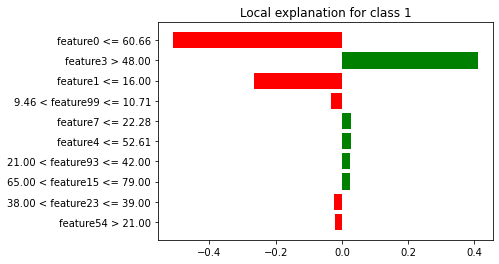

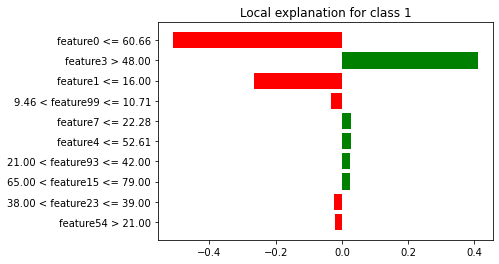

In [5]:
explainer = LimeTabularExplainer(X_train.values,feature_names=data.columns,discretize_continuous=True,discretizer="quartile",verbose=True,mode = "classification")
exp = explainer.explain_instance(X_test.iloc[0],xgb_clf.predict_proba,num_features=10)
exp.as_pyplot_figure()

In [6]:
predicted_class = xgb_clf.predict(X_test.iloc[:1])[0]
le = exp.local_exp[predicted_class]

m = exp.as_map()
for i in range(10):
    x = np.array(X_test.iloc[i:i+1])[0]
    coefs = np.zeros(X_test.shape[1])

    for v in le:
        coefs[v[0]] = v[1]


    base = np.zeros(X_test.shape[1])


    print("Faithfulness: ", faithfulness_metric(xgb_clf, x, coefs, base))
    print("Monotonity: ", monotonicity_metric(xgb_clf, x, coefs, base))

KeyError: 0